# Boundary Conditiond and Finite Differences 

This notebook explains how to enforce boundary conditions (BC) that involve derivatives. Such conditions are called [Neumann](https://en.wikipedia.org/wiki/Neumann_boundary_condition) or [Robin](https://en.wikipedia.org/wiki/Robin_boundary_condition) BC, depending on whether they involve the derivative alone (Neumann) or a linear combination of derivative and function value (Robin).

In [1]:
# Import things we'll need
from math import pi, sin, cos, tan, fabs, exp
from scipy.linalg import solve_banded
from numba import njit

import numpy as np
import matplotlib.pyplot as plt

## A test problem

As a running example, I'll solve the heat equation

$$
    \frac{\partial U}{\partial t} = \frac{\partial^2 U}{\partial x^2}
$$

on the domain $0 \leq x \leq 1$ with $t \geq 0$, initial condition $U(x,0) = 1$ and BC 

$$
    \frac{\partial U}{\partial x} = U \;\; \mbox{at $x=0$} \qquad \mbox{and} \qquad 
    \frac{\partial U}{\partial x} = -U \;\; \mbox{at $x=1$}
$$

for all $t > 0$. 

This problem is discussed on pages 29&ndash;38 of 

> GD Smith (), Numerical Solution of PDEs: Finite Difference Methods, 3rd ed., OUP.

and has analytic solution

$$
U = 4 \sum_{n=0}^\infty \frac{\sec(\alpha_n)}{3 + 4 \alpha_n^2} \, e^{-4 \alpha_n^2 t} \cos\left(2 \alpha_n (x - \frac{1}{2}) \right),
$$
where the $\alpha_n$ are the (infinitley many) positive solutions to $\alpha \tan(\alpha) = 1/2$.

Note that, in contrast to a typical option-pricing problem, this is a _forward_ heat equation and so we are given data at $t=0$ and want to propagate the solution forward in time, rather than backward from some known final payoff.

### Code for the analytic solution

We begin by computing the $\alpha_n$. To see how this works, rewrite the defining equation as
$
\displaystyle
\tan(\alpha) = \frac{1}{2 \alpha}
$
and then plot the left- and righthand sides of this equation on the same axes. The $\alpha_n$ will be the values of $\alpha$ at which the curves $\tan(\alpha)$ and $1/2\alpha$ cross.

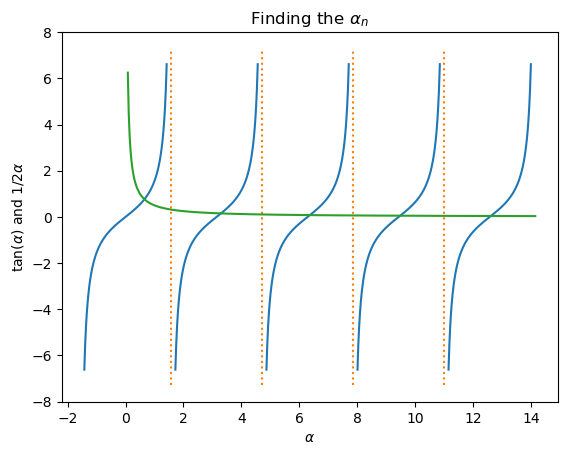

In [2]:
# Get ready to plot a cycle of the tangent
nSteps = 100
eps = 0.15 # keep away from singularities
alphaVals = np.linspace( start=-0.5*pi + eps, stop=0.5*pi - eps, num=(nSteps+1))
tanVals = np.array([tan(alpha) for alpha in alphaVals])

# Plot several cycles on the same axes
nCycles = 5
for j in range(nCycles):
    plt.plot( j*pi + alphaVals, tanVals, c='C0' )

# Add dotted vertical lines at the singularities
xmin, xmax, ymin, ymax = plt.axis() # Get the limits of the axes
for j in range(nCycles-1):
    plt.vlines( x=(j + 0.5)*pi, ymin=ymin, ymax=ymax, colors='C1', linestyles='dotted' )

# Add a curve for 1/(2 * alpha)
eps = 0.08
alphaVals = np.linspace( start=eps, stop=(nCycles - 0.5)*pi, num=int((nCycles - 0.5)*nSteps)+1)
curveVals = np.array([1.0/(2 * alpha) for alpha in alphaVals])
plt.plot( alphaVals, curveVals, c='C2' )
plt.xlabel( '$\\alpha$' )
plt.ylabel( '$\\tan(\\alpha)$ and $1/2 \\alpha$' )
plt.title( 'Finding the $\\alpha_n$' )
plt.show()


Here the curves for $\tan(\alpha)$ are blue, while $1/(2 \alpha)$ is plotted in green. The dotted vertical lines at $\alpha = n\pi + \pi/2$ indicate singularities of $\tan(\alpha)$.

The plot makes it clear that the $\alpha_n$ are near $n\pi$ for $n = 0, 1, 2, \dots$, so we can seek them using Newton's method.

In [3]:
@njit
def findAlpha( n, maxCycles=20, tol=1.0e-12 ):
    # Choose an initial guess
    if( n > 0):
        alpha = n*pi
    else:
        alpha = pi/4 # Starting guess for n=0

    # Use Newton's method to find a solution of alpha*tan(alpha) - 0.5 = 0
    f = lambda x: x*tan(x) - 0.5 # define the target once and for all
    
    nCycles = 0
    val = f(alpha)
    while (nCycles < maxCycles) and (fabs(val) > tol):
        deriv = tan(alpha) + alpha/(cos(alpha)*cos(alpha))
        alpha -= val/deriv
        val = f(alpha)
        nCycles += 1

    return( alpha )

# Do a small test: the result should be near 1.0
findAlpha(1) / pi

1.0479748281560544

In [4]:
nTerms = 100 # We need to truncate the infinite sum
alphaVals = np.array( [findAlpha(n) for n in range(nTerms)] )
alphaVals[0:5] / pi # for n > 0, alpha_n should be near n*pi

array([0.20794268, 1.04797483, 2.02496666, 3.0167774 , 4.0126187 ])

Once we have the $\alpha_n$, we can write a fast function to evaluate the analytic solution.

In [5]:
@njit
def analyticSolution(x, t, alphaVals):
    if t == 0:
        result = 1.0 
    else:
        result = 0.0
        for alpha in alphaVals:
            alphaSq = alpha*alpha
            coef = 4.0 / ((3.0 + 4.0*alphaSq)*cos(alpha))
            term = coef * exp(-4.0*alphaSq*t) * cos(2.0*alpha*(x - 0.5))
            result += term

    return( result )

The plot below shows curves $U(x,t)$ for $0 \leq x \leq 1$ at various values of $t$. $U(x,t)$ relaxes to zero fairly rapidly.

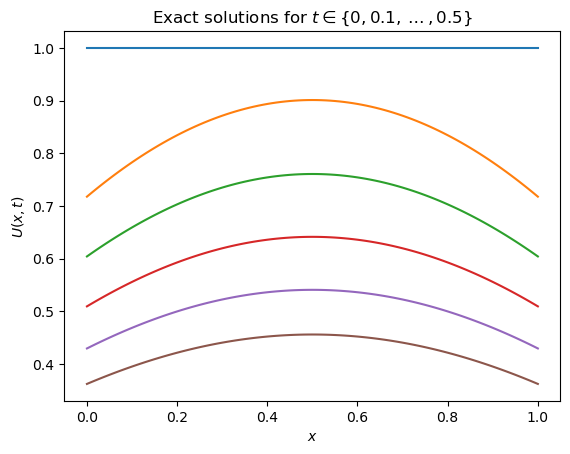

In [6]:
tMax = 0.5
tVals = np.linspace( 0.0, tMax, 6 )
xVals = np.linspace( 0.0, 1.0, nSteps+1 )
for t in tVals:
    uVals = np.array( [analyticSolution(x, t, alphaVals) for x in xVals] )
    plt.plot( xVals, uVals )

plt.xlabel( "$x$" )
plt.ylabel( "$U(x, t)$" )
plt.title( "Exact solutions for $t \\in \\{0, 0.1, \\dots, 0.5\\}$" )
plt.show()

## A first Crank-Nicolson scheme

We now want to solve the PDE numerically using a Crank-Nicolson scheme. If we write $U^{i}_j$ to mean
$U(x=j\Delta x, \, t=i\Delta t)$, then the usual sorts of calculation (see, for example, [solutions](https://github.com/VenetianRed/MATH60082-python/blob/main/solutions/MATH60082-lab-solution-9.ipynb) from the lab for Week&nbsp;9) the lead to
$$
\frac{\partial U}{\partial t} \approx \frac{U_j^{i+1}-U_j^i}{\Delta t}
$$
and
$$
\frac{\partial^2 U}{\partial x^2} \approx 
\frac{1}{2\Delta x^2}(U^i_{j+1}-2U_j^i
+U^i_{j-1}+U_{j+1}^{i+1}-2U_j^{i+1}
+U_{j-1}^{i+1})
$$
where the partial derivatives are imagined to be evaluated at points $(j\times \Delta x, \, (i + 1/2)\times \Delta t)$ and the finite-difference approximations are accurate to $O(\Delta t^2)$ and
$O(\Delta x^2)$.

Plugging these into the PDE and rearanging them to put function values from the same time on the same side of the equation yields
$$
    -r U^{i+1}_{j-1} + 2(1 + r)U^{i+1}_{j} - rU^{i+1}_{j+1} = 
    rU^{i}_{j-1} + 2(1 - r)U^{i}_{j} + rU^{i}_{j+1}
$$
where $r = \Delta t / \Delta x^2$. Writing this in the standard Crank-Nicolson way, we find
$$
    a_j U^{i+1}_{j-1} + b_j U^{i+1}_{j} + c_j U^{i+1}_{j+1} = d_j
$$
with
$$
    a_j = -r, \;\;
    b_j = 2(1 + r), \;\;
    c_j = -r \qquad \mbox{and} \qquad 
    d_j = rU^{i}_{j-1} + 2(1 - r)U^{i}_{j} + rU^{i}_{j+1}.
$$

These equations hold for $j \in \{1, \dots, $ `jMax` $-1 \}$ and correspond to demanding that the PDE be satisfied at points with coordinates $(j\times \Delta x, \, (i + 1/2)\times \Delta t)$.

#### Boundary conditions

We now enforce the boundary conditions to get equations for $j = 0$ and $j = $ `jMax`. The simplest approach is to use the $O(\Delta x)$ approximation
$$
    \left. \frac{\partial U}{\partial x} \right|_{x=0, \, t=i\times\Delta t} \approx
    \frac{U^i_{1} - U^i_{0}}{\Delta x} 
$$
so that the boundary condition at $x=0$ becomes
$$ 
\frac{U^{i+1}_{1} - U^{i+1}_{0}}{\Delta x} = U^{i+1}_0
$$
or, multiplying by $\Delta x$ and rearranging,
$$
\begin{align*}
    U^{i+1}_{1} - U^{i+1}_{0} & = \Delta x U^{i+1}_0  \\
    (1 + \Delta x)U^{i+1}_0 - U^{i+1}_{1} & = 0
\end{align*}
$$
which is of the form
$$
    b_0 U^{i+1}_0 + c_0 U^{i+1}_1 = d_0
$$
with
$$
    b_0 = (1 + \Delta x), \;\;
    c_0 = -1 \qquad \mbox{and} \qquad 
    d_0 = 0.
$$

Similar reasoning applied to the boundary condition at $x=1$ leads to 
$$
    a_{\texttt{jMax}} U^{i+1}_{\texttt{jMax-1}} + b_{\texttt{jMax}} U^{i+1}_{\texttt{jMax}} = d_{\texttt{jMax}}
$$
with
$$
    a_{\texttt{jMax}} = -1, \;\;
    b_{\texttt{jMax}} = 1 + \Delta x \qquad \mbox{and} \qquad 
    d_{\texttt{jMax}} = 0.
$$


As in the lab sessions about Crank-Nicolson, we use  SciPy's `solve_banded()` function to solve $A \boldsymbol{U^{i+1}} = \boldsymbol{d^{i}}$.  See the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_banded.html#scipy.linalg.solve_banded) for more details.

We'll store $A$'s diagonal bands in a $3 \times \mbox{(\texttt{jMax + 1})}$ matrix `A_bands` in such a way that:

* `A_bands[2,j-1]` $= a_{j}$
* `A_bands[1,j]` $= b_j$
* `A_bands[0,j+1]` $= c_j$

This storage pattern is expected by `solve_banded()`, whose documentation says that one should construct a matrix `ab` whose relation to the full matrix `a` is 
```
ab[u + i - j, j] = a[i,j]
```
where `u` is the number of non-empty diagonals above the main one and `l` is the number of non-empty diagonals below the main one: for us, `u = l = 1`.

In [7]:
def HeatEqn_CN1( iMax, jMax, tMax ):
    # Compute the step sizes and r
    xVals = np.linspace( 0.0, 1.0, (jMax + 1) )
    tVals = np.linspace( 0.0, tMax, (iMax + 1) )
    dx = xVals[1] - xVals[0]
    dt = tVals[1] - tVals[0]
    r = dt / (dx * dx) 

    # Set up storage for the tri-diagonal matrix A
    A_bands = np.zeros(shape=(3,jMax+1)) 
    
    # Set up a tuple that described the bands in our matrix
    u=1 # number of bands above the main diagonal
    l=1 # number of bands below the main diagonal
    l_and_u = (l, u) # needed for solve_banded()

    # Enforce the boundary condition at x=0
    A_bands[1,0] = (1.0 + dx) # b_0 = (1 + dx)
    A_bands[0,1] = -1.0 # c_0 = 1
    
    # Set a[j], b[j] and c[j] for the middle rows
    for j in range(1,jMax):
        A_bands[2,j-1] = -r # a_j
        A_bands[1,j] = 2*(1.0+r) # b_j
        A_bands[0,j+1] = -r # c_j
        
    # Enforce the boundary condition at x=1
    A_bands[2,jMax-1] = -1.0 # a_jMax = -1
    A_bands[1,jMax] = (1.0 + dx) # b_jMax = 1 + dx

    # Initialize the result and allocate two scratch spaces
    result = np.zeros( (jMax+1,iMax+1) )
    uNow = np.zeros( jMax + 1 )
    uNext = np.zeros( jMax + 1 )

    # Install the initial condition
    for j in range(jMax+1):
        uNow[j] = 1.0
        result[j,0] = 1.0

    # Time step along
    d = np.zeros( jMax + 1 )
    for i in range(iMax):
        # Fill d with values depending on U^{i}_j, which are
        # stored in uNow[].
        d[0] = 0.0 # Boundary condition at x=0.
        for j in range(1,jMax):
            d[j] = 2.0*(1.0 - r)*uNow[j] + r*(uNow[j-1] + uNow[j+1])
            
        d[jMax] = 0.0 # Boundary condtion at x=1

        # Solve the tridiagonal system
        uNext = solve_banded( l_and_u, A_bands, d )
        
        # Record the result, then move on to the next step
        result[:,i+1] = uNext
        uNow = np.copy(uNext)

    # Return the results
    return xVals, tVals, result



#### Comparison with the exact solution

In [8]:
tMax = 0.5
iMax = 200
jMax = 200
xVals, tVals, CN1_result = HeatEqn_CN1( iMax, jMax, tMax )

First, we need to compute the exact solution.

In [9]:
exact_result = np.zeros((jMax+1,iMax+1))
for i in range(iMax+1):
    for j in range(jMax+1):
        exact_result[j,i] = analyticSolution(xVals[j], tVals[i], alphaVals)

Now let's see how our first Crank-Nicolson result differs from the exact solution. The colour scheme or the curves is the same as that in the plot of exact solutions.

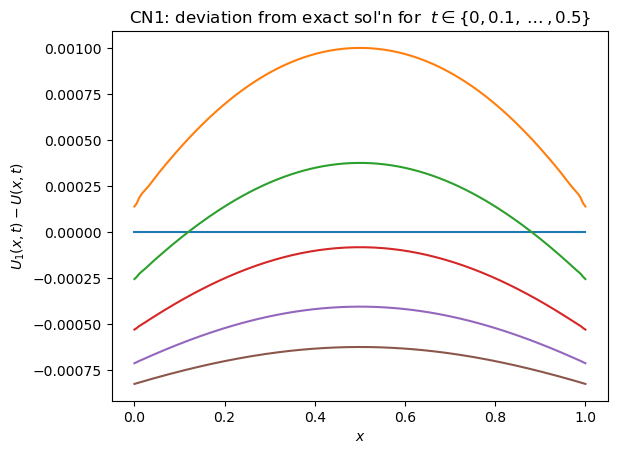

In [10]:
iStep = iMax // 5
for i in range(6):
    diffVals = np.array( CN1_result[:,iStep*i] - exact_result[:,iStep*i] )
    plt.plot( xVals, diffVals )

plt.xlabel( "$x$" )
plt.ylabel( "$U_1(x, t) - U(x,t)$" )
plt.title( "CN1: deviation from exact sol'n for  $t \\in \\{0, 0.1, \\dots, 0.5\\}$" )
plt.show()

Here I calculate a measure of error &mdash; the _root mean square (RMS) error_ &mdash; that is an approximation to
$$
    R(t_i) = \left[\int_{0}^1 \left( U_{CN}(x,t_i) - U(x,t_i)\right)^2 \, dx \right]^{1/2} \approx \sqrt{\frac{1}{\texttt{jMax}}\sum_{j=0}^{\texttt{jMax}} \left(U_{CN}(x_j, t_i) - U(x_j, t_i)\right)^2}
$$
where $U_{CN}(x,t)$ is the Crank-Nicolson solution and $U(x,t)$ is the exact solution. I evaluate this at all times $t_i = i \times \Delta t$ for $i \in \{0, 1, \dots, \mbox{\texttt{iMax}}\}$.

In [11]:
diff1 = CN1_result - exact_result
rms_diff1 = np.sqrt(np.sum(diff1*diff1, axis=0)/jMax) # finds RMS difference as a function of time
rms_diff1

array([0.        , 0.00538469, 0.00353094, 0.00292723, 0.00252631,
       0.00226926, 0.00205768, 0.00190062, 0.00176392, 0.00165696,
       0.0015626 , 0.00148716, 0.00142018, 0.0013657 , 0.00131674,
       0.00127602, 0.00123874, 0.00120684, 0.00117698, 0.00115061,
       0.00112539, 0.00110246, 0.00108015, 0.00105936, 0.00103887,
       0.00101944, 0.00100014, 0.00098159, 0.0009631 , 0.00094517,
       0.00092726, 0.00090979, 0.00089234, 0.00087524, 0.00085818,
       0.00084141, 0.00082469, 0.00080822, 0.00079182, 0.00077565,
       0.00075956, 0.00074368, 0.00072789, 0.00071229, 0.0006968 ,
       0.00068149, 0.00066629, 0.00065127, 0.00063638, 0.00062164,
       0.00060704, 0.0005926 , 0.0005783 , 0.00056415, 0.00055016,
       0.00053631, 0.00052262, 0.00050907, 0.0004957 , 0.00048245,
       0.00046939, 0.00045647, 0.00044374, 0.00043113, 0.00041874,
       0.00040647, 0.00039443, 0.00038252, 0.00037085, 0.00035931,
       0.00034802, 0.00033688, 0.00032602, 0.0003153 , 0.00030

## A second Crank-Nicolson scheme: introducting &ldquo;ghost points&rdquo;

The derivative approximation used above for the boundary condition was only $O(\Delta x)$, while the Crank-Nicolson scheme is $O(\Delta x^2)$. It makes sense, then, to try to use an $O(\Delta x^2)$ approximation to the derivative. A natural candidate is a centred-difference approximation. To do this, we introduce a fictitious grid point at $(-\Delta x, \, i \times \Delta t)$ (sometimes called a _ghost point_) and write formulae involving it.  The centred-difference approximation for the derivative is
$$
    \left. \frac{\partial U}{\partial x} \right|_{x=0, \, t=i\times\Delta t} \approx \frac{U^i_{1} - U^i_{-1}}{2 \Delta x}
$$
and so the boundary condition at $x=0$ becomes
$$
    \frac{U^i_{1} - U^i_{-1}}{2 \Delta x} = U^i_{0}
$$
which, after some rearrangement, yields
$$
    U^i_{-1} = U^i_{1} - 2 \Delta x U^i_{0}
$$

If we now demand that the PDE is satisfied at $(x=0, \, t=(i + 1/2)\times \Delta t)$ we get an equation that looks like
$$
    -r U^{i+1}_{-1} + 2(1 + r)U^{i+1}_{0} - rU^{i+1}_{1} = 
    rU^{i}_{-1} + 2(1 - r)U^{i}_{0} + rU^{i}_{1}.
$$
We can use our result from above to eliminate $U^i_{-1}$ and $U^{i+1}_{-1}$ to obtain
$$
    -r \left( U^{i+1}_{1} - 2 \Delta x U^{i+1}_{0}\right) + 2(1 + r)U^{i+1}_{0} - rU^{i+1}_{1} = 
    r\left( U^{i}_{1} - 2 \Delta x U^{i}_{0}\right) + 2(1 - r)U^{i}_{0} + rU^{i}_{1} 
$$
which simplifies to 
$$
    2(1 + r + r \Delta x)U^{i+1}_{0} - 2rU^{i+1}_{1} = 2(1 - r - r \Delta x)U^{i}_{0} + 2rU^{i}_{1}.
$$
This is of the form
$$
    b_0 U^{i+1}_0 + c_0 U^{i+1}_1 = d_0
$$
with
$$
    b_0 = 2(1 + r + r \Delta x), \;\;
    c_0 = -2r \qquad \mbox{and} \qquad 
    d_0 = 2(1 - r - r \Delta x)U^{i}_{0} + 2rU^{i}_{1},
$$
which we can incorporate into our tridiagonal system to impose the boundary condition at $x=0$.

Similar reasoning applied to the boundary condition at $x=1$ leads to 
$$
    a_{\texttt{jMax}} U^{i+1}_{\texttt{jMax-1}} + b_{\texttt{jMax}} U^{i+1}_{\texttt{jMax}} = d_{\texttt{jMax}}
$$
with
$$
    a_{\texttt{jMax}} = -2r, \;\;
    b_{\texttt{jMax}} = 2(1 + r + r \Delta x) \qquad \mbox{and} \qquad 
    d_{\texttt{jMax}} = 2(1 - r - r \Delta x)U^{i}_{\texttt{jMax}} + 2rU^{i}_{\texttt{jMax-1}}.
$$

In [12]:
def HeatEqn_CN2( iMax, jMax, tMax ):
    # Compute the step sizes and r
    xVals = np.linspace( 0.0, 1.0, (jMax + 1) )
    tVals = np.linspace( 0.0, tMax, (iMax + 1) )
    dx = xVals[1] - xVals[0]
    dt = tVals[1] - tVals[0]
    r = dt / (dx * dx) 

    # Set up storage for the tri-diagonal matrix A
    A_bands = np.zeros(shape=(3,jMax+1)) 
    
    # Set up a tuple that described the bands in our matrix
    u=1 # number of bands above the main diagonal
    l=1 # number of bands below the main diagonal
    l_and_u = (l, u) # needed for solve_banded()

    # Enforce the boundary condition at x=0
    A_bands[1,0] =  2.0*(1.0 + r + r*dx) # b_0 = 2(1 + r + r*dx)
    A_bands[0,1] = -2.0*r # c_0 = 2r
    
    # Set a[j], b[j] and c[j] for the middle rows
    for j in range(1,jMax):
        A_bands[2,j-1] = -r # a_j
        A_bands[1,j] = 2*(1.0+r) # b_j
        A_bands[0,j+1] = -r # c_j
        
    # Enforce the boundary condition at x=1
    A_bands[2,jMax-1] = -2.0*r # a_jMax = 2r
    A_bands[1,jMax] = 2.0*(1.0 + r + r*dx) # b_jMax = 2(1 + r + r*dx)

    # Initialize the result and allocate two scratch spaces
    result = np.zeros( (jMax+1,iMax+1) )
    uNow = np.zeros( jMax + 1 )
    uNext = np.zeros( jMax + 1 )

    # Install the initial condition
    for j in range(jMax+1):
        uNow[j] = 1.0
        result[j,0] = 1.0

    # Time step along
    d = np.zeros( jMax + 1 )
    for i in range(iMax):
        # Fill d with values depending on U^{i}_j, which are
        # stored in uNow[].
        d[0] =  2.0*(1 - r - r*dx)*uNow[0] + 2.0*r*uNow[1] # Boundary condition at x=0.
        for j in range(1,jMax):
            d[j] = 2.0*(1.0 - r)*uNow[j] + r*(uNow[j-1] + uNow[j+1])
            
        d[jMax] = 2.0*(1 - r - r*dx)*uNow[jMax] + 2.0*r*uNow[jMax-1] # Boundary condtion at x=1

        # Solve the tridiagonal system
        uNext = solve_banded( l_and_u, A_bands, d )
        
        # Record the result, then move on to the next step
        result[:,i+1] = uNext
        uNow = np.copy(uNext)

    # Return the results
    return xVals, tVals, result


#### Comparison with the exact solution

In [13]:
xVals, tVals, CN2_result = HeatEqn_CN2( iMax, jMax, tMax )

As the plot below makes clear, the only substantial deviations from the exact solution happen near the boundaries.

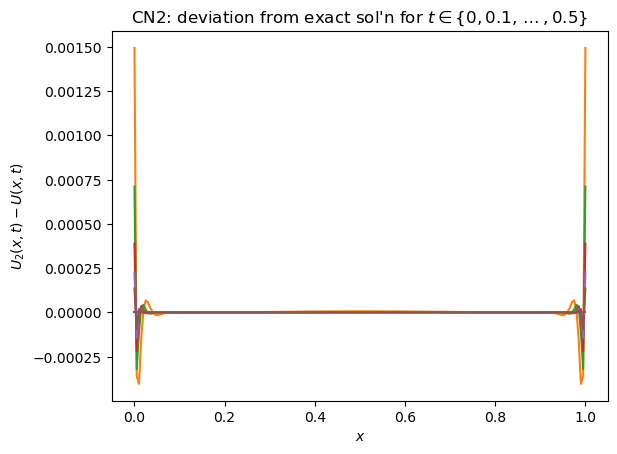

In [14]:
for i in range(6):
    diffVals = np.array( CN2_result[:,iStep*i] - exact_result[:,iStep*i]  )
    plt.plot( xVals, diffVals )
    
plt.xlabel( "$x$" )
plt.ylabel( "$U_2(x,t) - U(x, t)$" )
plt.title( "CN2: deviation from exact sol'n for $t \\in \\{0, 0.1, \\dots, 0.5\\}$" )
plt.show()

#### Comparison with the $O(\Delta x)$ approximation of the boundary conditions

In [15]:
diff2 = CN2_result - exact_result
rms_diff2 = np.sqrt(np.sum(diff2*diff2, axis=0)/jMax)

The RMS error is smaller at all $t_i$ if we use the $O(\Delta x^2)$ approximation to the derivative.

In [16]:
# Compute the ratio of RMS errors, skipping the initial condition as both
# approaches compute this exactly.
err_ratio21 = rms_diff2[1:(iMax+1)] / rms_diff1[1:(iMax+1)]
err_ratio21

array([0.37692306, 0.3495178 , 0.33484722, 0.31449781, 0.30886189,
       0.29750985, 0.29553113, 0.28802747, 0.28711134, 0.28101789,
       0.27992793, 0.2741167 , 0.27248211, 0.26664439, 0.26457742,
       0.25879844, 0.25655787, 0.25102593, 0.24883884, 0.24371138,
       0.24172229, 0.23709198, 0.23537189, 0.23127504, 0.22984604,
       0.22628125, 0.22513826, 0.22208279, 0.22120838, 0.21862956,
       0.21800269, 0.21586496, 0.21546561, 0.21373453, 0.21354584,
       0.21219013, 0.21219921, 0.21119174, 0.21138971, 0.21070778,
       0.21108958, 0.21071493, 0.21127901, 0.21119764, 0.21194561,
       0.21214761, 0.21308397, 0.21356328, 0.21469528, 0.21544951,
       0.21678697, 0.21781728, 0.21937256, 0.22068358, 0.22247156,
       0.22407124, 0.22610934, 0.22800895, 0.23031715, 0.23253113,
       0.23513191, 0.23767769, 0.2405959 , 0.24349355, 0.24675597,
       0.25002753, 0.25366216, 0.25733044, 0.26136503, 0.26545166,
       0.26991129, 0.27443339, 0.27933642, 0.28430146, 0.28965

### LU decomposition and acceleration

If we want to use `numba` to accelerate this solver, we need to replace the call to `solve_banded()` with code of our own. The version below uses an LU decomposition as described in Section 7.3 of the lecture notes as well as on pages 24&ndash;25 of
> GD Smith (1985), _Numerical Solution of PDEs: Finite Difference Methods_, 3rd edition, OUP.

I'll store the diagonals of $A$ in a `(jMax+1)` $\times 3$ array `A_diags` where:
* `A_diags[j,0]` $= a_j$ (and hence is undefined for $j=0$)
* `A_diags[j,1]` $= b_j$ (and hence is defined for $0 \leq j \leq$ `jMax`)
* `A_diags[j,2]` $= c_j$ (and hence is undefined for $j =$ `jMax`)

In [17]:
@njit
def HeatEqn_CN2a( iMax, jMax, tMax ):
    # Compute the step sizes and r
    xVals = np.linspace( 0.0, 1.0, (jMax + 1) )
    tVals = np.linspace( 0.0, tMax, (iMax + 1) )
    dx = xVals[1] - xVals[0]
    dt = tVals[1] - tVals[0]
    r = dt / (dx * dx) 

    # Set up storage for the tri-diagonal matrix A
    # as described above.
    A_diags = np.zeros(shape=(jMax+1,3)) 
        
    # Enforce the boundary condition at x=0
    A_diags[0,1] = 2.0*(1.0 + r + r*dx) # b_0 = 2(1 + r + r*dx)
    A_diags[0,2] = -2.0*r # c_0 = 2r
    
    # Set a[j], b[j] and c[j] for the middle rows
    for j in range(1,jMax):
        # a_j V_j-1 + b_j V_j + c_i V_j+1 = d_i
        A_diags[j,0] = -r # a_j
        A_diags[j,1] = 2*(1.0+r) # b_j
        A_diags[j,2] = -r # c_j
        
    # Enforce the boundary condition at x = 1
    # a_jMax V_jMax-1 + b_jMax V_jMax = d_jMax
    A_diags[jMax,0] = -2.0*r # a_jMax = 2r
    A_diags[jMax,1] = 2.0*(1.0 + r + r*dx) # b_jMax = 2(1 + r + r*dx)

    # Initialize the result and allocate four scratch spaces, two
    # for values of u(x,t) and three, alpha, beta and dPrime, for intermediate 
    # results in LU decomposition
    result = np.zeros( (jMax+1,iMax+1) )
    uNow = np.zeros( jMax + 1 )
    uNext = np.zeros( jMax + 1 )
    alpha = np.zeros( jMax + 1 )
    beta = np.zeros( jMax + 1 )
    dPrime = np.zeros( jMax + 1 )

    # Install the initial condition
    for j in range(jMax+1):
        uNow[j] = 1.0
        result[j,0] = 1.0

    # Time step along
    d = np.zeros( jMax + 1 )
    for i in range(iMax):
        # Fill d with values depending on U^{i}_j, which are
        # stored in uNow[].
        d[0] =  2.0*(1 - r - r*dx)*uNow[0] + 2.0*r*uNow[1] # Boundary condition at x=0.
        for j in range(1,jMax):
            d[j] = 2.0*(1.0 - r)*uNow[j] + r*(uNow[j-1] + uNow[j+1])
            
        d[jMax] = 2.0*(1 - r - r*dx)*uNow[jMax] + 2.0*r*uNow[jMax-1] # Boundary condtion at x=1

        ###############################################################
        # Solve the tridiagonal system using an LU decomposition
        ###############################################################
        beta[0] = A_diags[0,1] 
        dPrime[0] = d[0]
        for j in range(1, jMax+1):
            beta[j] = A_diags[j,1] - (A_diags[j,0]*A_diags[j-1,2]/beta[j-1])
            dPrime[j] = d[j] - (A_diags[j,0]*dPrime[j-1]/beta[j-1])

        # Now backsolve 
        uNext[jMax] = dPrime[jMax] / beta[jMax]
        for j in range(jMax-1, -1, -1):
            uNext[j] = (dPrime[j] - A_diags[j,2]*uNext[j+1])/beta[j]
        
        ###############################################################
        # End of LU solver
        ###############################################################
        
        # Record the result, then move on to the next step
        result[:,i+1] = uNext
        uNow = np.copy(uNext)

    # Return the results
    return xVals, tVals, result


In [18]:
xVals, tVals, CN2a_result = HeatEqn_CN2a( iMax, jMax, tMax )

This version gives essentially the same result as the version that uses `solve_banded()`:

In [19]:
maxDiff = np.max(np.abs(CN2a_result - CN2_result))
print( f'Max difference between CN2a_result and CN2_result is {maxDiff:.4e}' )

Max difference between CN2a_result and CN2_result is 7.6716e-14


In [20]:
# Do some timing experiments
from timeit import timeit

nReps = 100
CN2_time = timeit( "HeatEqn_CN2( iMax, jMax, tMax )", number=nReps, globals=globals() )
print( f"{nReps} repetitions of HeatEqn_CN2() took {CN2_time:.2f} seconds." )

CN2a_time = timeit( "HeatEqn_CN2a( iMax, jMax, tMax )", number=nReps, globals=globals() )
print( f"{nReps} repetitions of HeatEqn_CN3() took {CN2a_time:.4f} seconds." )

ratio = CN2_time/CN2a_time
print( f"That's a speedup by a factor of around {ratio:.0f}." )

100 repetitions of HeatEqn_CN2() took 1.66 seconds.
100 repetitions of HeatEqn_CN3() took 0.0638 seconds.
That's a speedup by a factor of around 26.


## A third Crank-Nicolson scheme: $O(\Delta x^2)$ without ghosts

The $O(\Delta x^2)$ approximations to the derivatives that we used above are a special case of a family of approximations called _three-point formulae_ because they involve linear combinations of values of the function at three grid points. You can read more about them in any of the following:
* the _Wikipedia_ page about [numerical differentiation](https://en.wikipedia.org/wiki/Numerical_differentiation),
* Section 5.7 of [Numerical Recipes](https://numerical.recipes/book.html), which is one of the recommended books for the course.

The centred-difference approximations are attractive for several reasons. Not only are they $O(\Delta x^2)$, but it's also true that _all_ the nonvanishing terms in the power series for the error have even exponents. That is, we can think of the error for a centred-difference approximation as a power series in $\Delta x^2$.

But sometimes, as for example in the first part of the final assignment, one can't use the ghost point approach and so is forced to use one of the other three-point formulae. Consider the following Taylor expansions:
$$
\begin{align*}
    f(x + \Delta x) & = f(x) + \Delta x f'(x) + \frac{\Delta x^2}{2} f''(x) + \frac{\Delta x^3}{3!} f'''(x) + O(\Delta x^4) \\
    f(x + 2\Delta x) & = f(x) + 2\Delta x f'(x) + \frac{4\Delta x^2}{2} f''(x) + \frac{8\Delta x^3}{3!} f'''(x) + O(\Delta x^4) \\
\end{align*}
$$
Multiplying the first by 4 and subtracting the second yields:
$$
4f(x + \Delta x) - f(x + 2\Delta x) = 3f(x) + 2\Delta xf'(x) - \frac{4\Delta x^3}{3!} f'''(x) + O(\Delta x^4)
$$
and rearranging this leads to
$$
\frac{4f(x + \Delta x) - f(x + 2\Delta x) - 3f(x)}{2 \Delta x} = f'(x) + O(\Delta x^2).
$$
which is sometimes called the _three-point, forward-difference formula_.

---

Applying the new three-point, forward-difference approximation to the heat equation gives
$$
    \left. \frac{\partial U}{\partial x} \right|_{x=0, \, t=(i+ 1/2)\times\Delta t} \approx \frac{1}{2} \left( \frac{4U^{i}_{1} - U^{i}_{2} - 3U^{i}_0}{2 \Delta x} + \frac{4U^{i+1}_{1} - U^{i+1}_{2} - 3U^{i+1}_0}{2 \Delta x}  \right)
$$
and so the boundary condition at $(x=0, t=(i + 1/2)\Delta t)$ becomes
$$
    \frac{4U^{i}_{1} - U^{i}_{2} - 3U^{i}_0 + 4U^{i+1}_{1} - U^{i+1}_{2} - 3U^{i+1}_0}{4 \Delta x} = \frac{U^{i}_{0} + U^{i+1}_{0}}{2},
$$
where the expression on the right is an $O(\Delta x^2)$ approximation to $U(x=0, t=(i + 1/2)\Delta t)$. After some rearrangement, this leads to
$$
    -(3 + 2 \Delta x) U^{i+1}_0 + 4 U^{i+1}_1 - U^{i+1}_2 = 
    (3 + 2\Delta x) U^{i}_0 -4 U^{i}_1 + U^{i}_2
$$
which is not quite of the form
$$
    b_0 U^{i}_0 + c_0 U^{i+1}_1 = d_0
$$
that our tridiagonal solvers expect. 

Let's look more closely at the top few rows of our system of linear equations:
$$
\left\lceil 
    \begin{array}{cccccc}
        -(3 + 2 \Delta x) & 4 & -1 & 0 & 0 & \cdots  \\
        a_1 & b_1 & c_1 & 0 & 0 & \cdots \\
        0 & a_2 & b_2 & c_2 & 0 & \cdots \\
        0 & 0 & \ddots & \ddots & \ddots & \ddots
    \end{array}
\right\rceil 
\left\lceil 
    \begin{array}{c}
        U^{i+1}_0 \\ U^{i+1}_1 \\  U^{i+1}_2 \\  \vdots \\
    \end{array}
\right\rceil 
\; = \; 
\left\lceil 
    \begin{array}{c}
        (3 + 2\Delta x) U^{i}_0 -4 U^{i}_1 + U^{i}_2 \\ d_1 \\  d_2 \\  \vdots \\
    \end{array}
\right\rceil, 
$$
where the top row corresponds to the three-point, forward-difference version of the boundary condition at $(x=0, t=(i+1/2)\Delta t)$, while the subsequent rows come from the Crank-Nicolson scheme.

If we now multiply the second row by $1/c_1$ and add it to the first, we get
$$
\left\lceil 
    \begin{array}{cccccc}
        (a_1/c_1)-(3 + 2 \Delta x) & 4 + (b_1/c_1) & 0 & 0 & 0 & \cdots  \\
        a_1 & b_1 & c_1 & 0 & 0 & \cdots \\
        0 & a_2 & b_2 & c_2 & 0 & \cdots \\
        0 & 0 & \ddots & \ddots & \ddots & \ddots
    \end{array}
\right\rceil 
\left\lceil 
    \begin{array}{c}
        U^{i}_0 \\ U^{i}_1 \\  U^{i}_2 \\  \vdots \\
    \end{array}
\right\rceil 
\; = \; 
\left\lceil 
    \begin{array}{c}
         (3 + 2\Delta x) U^{i}_0 -4 U^{i}_1 + U^{i}_2 + d_1/c_1 \\ 
         d_1 \\  d_2 \\  \vdots \\
    \end{array}
\right\rceil,
$$
which does have the desired form, with
$$
\begin{alignat*}{3}
    b_0 & = (a_1/c_1)-(3 + 2 \Delta x) &&= (-r)/(-r) -(3 + 2 \Delta x) && = -2(1 + \Delta x) \\
    c_0 & = 4 + (b_1/c_1) && = 4 + 2(1+r)/(-r) && = 2(1 - (1/r)) \\
    d_0 & = (3 + 2\Delta x) U^{i}_0 -4 U^{i}_1 + U^{i}_2 + d_1/c_1 && = (3 + 2\Delta x) U^{i}_0 -4 U^{i}_1 + U^{i}_2 - d_1/r  \\
\end{alignat*}
$$

where, to obtain the final expressions, I have used $a_1 = c_1 = -r$ and $b_1 = 2(1 + r)$. 

---

Similar considerations starting from the _three-point, backward-difference formula_
$$
f'(x) = \frac{f(x - 2 \Delta x) - 4 f(x - \Delta x) + 3f(x)}{2 \Delta x} + O(\Delta x^2)
$$
lead to the conclusion that the boundary condition at $(x=1, t=(i + 1/2)\Delta t)$ is
$$
    - U^{i+1}_{\texttt{jMax-2}} + 4 U^{i+1}_{\texttt{jMax-1}}  -(3 + 2 \Delta x) U^{i+1}_{\texttt{jMax}} = 
    U^{i}_{\texttt{jMax-2}} - 4 U^{i}_{\texttt{jMax-1}}  +(3 + 2 \Delta x) U^{i}_{\texttt{jMax}}
$$
which corresponds to taking
$$
\begin{alignat*}{2}
    a_{\texttt{jMax}} & = 4 + (b_{\texttt{jMax-1}}/a_{\texttt{jMax-1}}) && = 2(1 - (1/r)) \\
    b_{\texttt{jMax}} & = (c_{\texttt{jMax-1}}/a_{\texttt{jMax-1}})-(3 + 2 \Delta x) 
        && = -2(1 + \Delta x) \\
    d_{\texttt{jMax}} & = U^{i}_{\texttt{jMax-2}} - 4 U^{i}_{\texttt{jMax-1}}  +(3 + 2 \Delta x) U^{i}_{\texttt{jMax}} + d_{\texttt{jMax-1}}/a_{\texttt{jMax-1}} && = U^{i}_{\texttt{jMax-2}} - 4 U^{i}_{\texttt{jMax-1}}  +(3 + 2 \Delta x) U^{i}_{\texttt{jMax}} -d_{\texttt{jMax-1}}/r. \\
\end{alignat*}
$$

In [21]:
@njit
def HeatEqn_CN3a( iMax, jMax, tMax ):
    # Compute the step sizes and r
    xVals = np.linspace( 0.0, 1.0, (jMax + 1) )
    tVals = np.linspace( 0.0, tMax, (iMax + 1) )
    dx = xVals[1] - xVals[0]
    dt = tVals[1] - tVals[0]
    r = dt / (dx * dx) 

    # Set up storage for the tri-diagonal matrix A
    # as described above.
    A_diags = np.zeros(shape=(jMax+1,3)) 
        
    # Enforce the boundary condition at x=0
    A_diags[0,1] = -2.0*(1.0 + dx) # b_0 = -2(1 + dx)
    A_diags[0,2] = 2.0 - (2.0/r) # c_0 = 2(1 - (1/r))
    
    # Set a[j], b[j] and c[j] for the middle rows
    for j in range(1,jMax):
        # a_j V_j-1 + b_j V_j + c_i V_j+1 = d_i
        A_diags[j,0] = -r # a_j
        A_diags[j,1] = 2*(1.0+r) # b_j
        A_diags[j,2] = -r # c_j
        
    # Enforce the boundary condition at x = 1
    # a_jMax V_jMax-1 + b_jMax V_jMax = d_jMax
    A_diags[jMax,0] = 2.0 - (2.0/r) # a_jMax = 2(1 - (1/r))
    A_diags[jMax,1] = -2.0*(1.0 + dx) # b_jMax = -2(1 + dx)

    # Initialize the result and allocate four scratch spaces, two
    # for values of u(x,t) and three, alpha, beta and dPrime, for intermediate 
    # results in LU decomposition
    result = np.zeros( (jMax+1,iMax+1) )
    uNow = np.zeros( jMax + 1 )
    uNext = np.zeros( jMax + 1 )
    alpha = np.zeros( jMax + 1 )
    beta = np.zeros( jMax + 1 )
    dPrime = np.zeros( jMax + 1 )

    # Install the initial condition
    for j in range(jMax+1):
        uNow[j] = 1.0
        result[j,0] = 1.0

    # Time step along
    d = np.zeros( jMax + 1 )
    for i in range(iMax):
        # Fill d with values depending on U^{i}_j, which are
        # stored in uNow[].
        for j in range(1,jMax):
            d[j] = 2.0*(1.0 - r)*uNow[j] + r*(uNow[j-1] + uNow[j+1])

        d[0] = (3.0 + 2.0*dx)*uNow[0] - 4.0*uNow[1] + uNow[2] - d[1]/r # BC at x=0.
        d[jMax] = (3.0 + 2.0*dx)*uNow[jMax] - 4.0*uNow[jMax-1] + uNow[jMax-2] - d[jMax-1]/r # BC at x=1

        ###############################################################
        # Solve the tridiagonal system using an LU decomposition
        ###############################################################
        beta[0] = A_diags[0,1] 
        dPrime[0] = d[0]
        for j in range(1, jMax+1):
            beta[j] = A_diags[j,1] - (A_diags[j,0]*A_diags[j-1,2]/beta[j-1])
            dPrime[j] = d[j] - (A_diags[j,0]*dPrime[j-1]/beta[j-1])

        # Now backsolve 
        uNext[jMax] = dPrime[jMax] / beta[jMax]
        for j in range(jMax-1, -1, -1):
            uNext[j] = (dPrime[j] - A_diags[j,2]*uNext[j+1])/beta[j]
        
        ###############################################################
        # End of LU solver
        ###############################################################
        
        # Record the result, then move on to the next step
        result[:,i+1] = uNext
        uNow = np.copy(uNext)

    # Return the results
    return xVals, tVals, result


#### Comparison with the exact result

In [22]:
xVals, tVals, CN3a_result = HeatEqn_CN3a( iMax, jMax, tMax )

As with the the ghost point approach, this $O(\Delta x^2, \, \Delta t^2)$ algorithm gives very accurate results everywhere except near the boundaries.

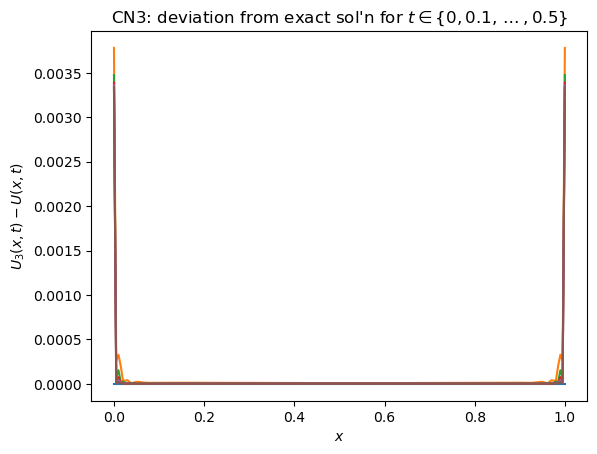

In [23]:
for i in range(6):
    diffVals = np.abs(np.array( CN3a_result[:,iStep*i] - exact_result[:,iStep*i]))
    plt.plot( xVals, diffVals )

plt.xlabel( "$x$" )
plt.ylabel( "$U_3(x, t) - U(x,t)$" )
plt.title( "CN3: deviation from exact sol'n for $t \\in \\{0, 0.1, \\dots, 0.5\\}$" )
plt.show()

#### Comparison with the other approximations to the boundary conditions

In [24]:
diff3 = CN3a_result - exact_result
rms_diff3 = np.sqrt(np.sum(diff3*diff3, axis=0)/jMax)

This approach isn't quite as accurate as the one based on centred-differences (that requires ghost points), but is, for most $t_i$, still better than the $O(\Delta x, \, \Delta t)$ approach.

In [25]:
# Compute the ratio of RMS errors, skipping the initial condition as both
# approaches compute this exactly.
err_ratio32 = rms_diff3[1:(iMax+1)] / rms_diff2[1:(iMax+1)]
err_ratio32

array([ 1.03821514,  1.05322966,  1.10359566,  1.11780253,  1.1660231 ,
        1.18173279,  1.22864583,  1.2456812 ,  1.29164329,  1.30974085,
        1.3549917 ,  1.37402485,  1.41884019,  1.43877801,  1.48339073,
        1.50423824,  1.54880873,  1.57058106,  1.61521602,  1.63792511,
        1.68270471,  1.70635185,  1.7513486 ,  1.77592231,  1.82121034,
        1.84668787,  1.89234567,  1.9186966 ,  1.96480626,  1.99199645,
        2.03864145,  2.06663668,  2.11389956,  2.14266833,  2.19062857,
        2.22014407,  2.26887657,  2.29911787,  2.34869197,  2.37964465,
        2.43012363,  2.46177991,  2.51322086,  2.54557948,  2.59803345,
        2.6310993 ,  2.68461167,  2.71839535,  2.77300629,  2.80752354,
        2.86326856,  2.89853977,  2.95545028,  2.99149995,  3.04960382,
        3.08646005,  3.14578214,  3.18347619,  3.24403884,  3.28260477,
        3.34442823,  3.38390249,  3.44700535,  3.48742652,  3.55182602,
        3.59323457,  3.65894689,  3.70138493,  3.76842549,  3.81

In [26]:
err_ratio31 = rms_diff3[1:(iMax+1)] / rms_diff1[1:(iMax+1)]
err_ratio31

array([0.39132723, 0.36812252, 0.36953594, 0.35154645, 0.3601401 ,
       0.35157714, 0.36310309, 0.35879041, 0.37084544, 0.36806061,
       0.37930002, 0.37664316, 0.38660857, 0.38364209, 0.3924717 ,
       0.3892945 , 0.39735907, 0.39425657, 0.40192848, 0.399181  ,
       0.40674723, 0.40456233, 0.41221823, 0.41072651, 0.41859799,
       0.41787085, 0.42603942, 0.4261095 , 0.43463161, 0.43550931,
       0.44442932, 0.44611445, 0.45547266, 0.4579622 , 0.46779963,
       0.47109267, 0.48145382, 0.4855547 , 0.49648931, 0.50140963,
       0.51297378, 0.51873378, 0.53099081, 0.53762038, 0.55064178,
       0.55818142, 0.57204772, 0.58054942, 0.59535135, 0.60487956,
       0.6207193 , 0.63135206, 0.6483447 , 0.66017491, 0.67845011,
       0.69158693, 0.71129074, 0.72586107, 0.74715779, 0.76330779,
       0.7863818 , 0.80427814, 0.82933534, 0.84916587, 0.87643428,
       0.89840756, 0.92813637, 0.95247902, 0.98493466, 1.0118849 ,
       1.04734222, 1.07713719, 1.11586254, 1.14871554, 1.19093